In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame
ep = 1e-7

##--------------------Data Preprocesseing -------------------------------

Train_X = []
Train_Y = []
y=0
for a,b,file in os.walk("horse-or-human/train"):
    for i in file:
        str1 = a+"/"+str(i)
        t = cv2.imread(str1)
        t = cv2.cvtColor(t,cv2.COLOR_BGR2GRAY)
        t = t/255
        t = t.reshape(10000)
        Train_X.append(t)
        Train_Y.append(y-1)
    y+=1

Test_X = []
Test_Y = []
y=0
for a,b,file in os.walk("horse-or-human/validation"):
    for i in file:
        str1 = a+"/"+str(i)
        t = cv2.imread(str1)
        t = cv2.cvtColor(t,cv2.COLOR_BGR2GRAY)
        t = t/255
        t = t.reshape(10000)  #vectorization
        Test_X.append(t)
        Test_Y.append(y-1)
    y+=1
print("loading the train img Complete : %d"%(len(Train_X)))
print("loading the validation img Complete : %d"%(len(Test_X)))


loading the train img Complete : 1027
loading the validation img Complete : 256


In [10]:
X1 = [] 
X2 = []  
X3 = []  

NodeSize = 20 
ActivationFuncion = "sigmoid" 
rate = 0.4
epoches = 1000  


np.random.seed(3)
if ActivationFuncion == "sigmoid" or ActivationFuncion == "tanh": # Xavier Initialization  (for gradient vanishing !!!!)
    w1 = np.random.randn(NodeSize, 10000) / np.sqrt(NodeSize)
    w2 = np.random.randn(NodeSize, NodeSize) / np.sqrt(NodeSize)
    w3 = np.random.randn(NodeSize, 1) / np.sqrt(NodeSize)
    b3 = 0.3
    b2 = np.random.randn(1, NodeSize)
    b1 = np.random.randn(1, NodeSize)
    print("sigmoid mode activate")
elif ActivationFuncion == "relu" or ActivationFuncion == "leakyrelu": # He Initialization (for Relu)
    w1 = np.random.randn(NodeSize, 10000) /np.sqrt(10000000)
    w2 = np.random.randn(NodeSize, NodeSize) /np.sqrt(NodeSize*1000)
    w3 = np.random.randn(NodeSize, 1) /(np.sqrt(1*1000))

    b3 = 0.01
    b2 = np.random.randn(1, NodeSize)/np.square(NodeSize)
    b1 = np.random.randn(1, NodeSize)/np.square(NodeSize)
    print("relu mode activate")

w1 = np.asarray(w1).T  # 10000 X 10
w2 = np.asarray(w2).T  # 10 x 10
w3 = np.asarray(w3).T  # 1 x 10
w3.resize([NodeSize,1])


b1 = np.asarray(b1).reshape([1,NodeSize]) # 1 X 10
b2 = np.asarray(b2).reshape([1,NodeSize]) # 1 X 10
b3 = np.asarray(b3)                       # 1 X 1

#시각화용
Train_Loss = []
Train_Acc = []
Val_Loss = []
Val_Acc = []


sigmoid mode activate


In [3]:
def ActFunc(type,z):
    if type == "sigmoid":
        return 1/(1+np.exp(-z))
    if type == "tanh":
        return (np.exp(z) - np.exp(-z))/(np.exp(z)+np.exp(-z))
    if type == "relu":
        return z * (z>0)
    if type == "leakyrelu":
        return np.where(z > 0, z, z * 0.01)

def derivAct(type,z):
    if type == "sigmoid":
        return ActFunc("sigmoid",z)*(1-ActFunc("sigmoid",z))
    if type == "tanh":
        return np.square(2/(np.exp(z)+np.exp(-z)))
    if type == "relu":
        return 1.*(z>0)
    if type == "leakyrelu":
        return np.where(z > 0, 1., -0.01)

def cross_entropy(py,y):
    sum = 0
    for i in range(len(py)):
        sum += -y[i]*np.log(py[i]+ep)-(1-y[i])*np.log(1-py[i]+ep)
    return sum/len(py)


def DataFoward(type,input):   # 입력 TX 출력 X1,X2,X3 (각 층의 출력값)
    TX = np.asarray(input)

    z1 = np.matmul(TX,w1)+b1
    a1 = ActFunc(type,z1)
    a1 = np.asarray(a1)

    z2 = np.matmul(a1,w2)+b2
    a2 = ActFunc(type,z2)
    a2 = np.asarray(a2)

    z3 = np.matmul(a2,w3)+b3
    a3 = ActFunc("sigmoid",z3)  # 출력층으로는 sigmoid
    a3 = np.asarray(a3)
    return (z1,z2,z3,a1,a2,a3)


def BackPropagation(type,A1,A2,A3,Z1,Z2,Z3): # 입력 A1,A2,A3  출력 W1,W2,W3,B1,B2,B3 (수정된 각층의 가중치와 바이어스)
    TX = np.asarray(Train_X)
    TY = np.asarray(Train_Y).reshape([1027,1])

    loss3 = (1/len(A3))*(A3 - TY)*derivAct(type,Z3)
    loss3 = np.asarray(loss3)
    bloss3 = np.sum(loss3)

    loss2 = np.matmul(loss3,w3.T)*derivAct(type,Z2)
    bloss2 = loss2.sum(axis=0)
    bloss2 = bloss2.reshape([1,NodeSize])

    loss1 = np.matmul(loss2,w2.T)*derivAct(type,Z1)
    bloss1 = loss1.sum(axis=0)
    bloss1 = bloss1.reshape([1, NodeSize])

    w3.resize([NodeSize,1])

    W3 = w3-rate*np.matmul(A2.T,loss3)
    B3 = b3-rate*bloss3
    W2 = w2-rate*np.matmul(A1.T,loss2)
    B2 = b2-rate*bloss2
    W1 = w1-rate*np.matmul(TX.T,loss1)
    B1 = b1-rate*bloss1

    W3 = np.asarray(W3)
    W2 = np.asarray(W2)
    W1 = np.asarray(W1)
    B3 = np.asarray(B3)
    B2 = np.asarray(B2).reshape([1,NodeSize])
    B1 = np.asarray(B1).reshape([1,NodeSize])

    return (W1,W2,W3,B1,B2,B3)


In [11]:
#learning

result = []
bestAcc = 0
bestLoss = 1000
for i in range(epoches):
    (Z1,Z2,Z3,A1,A2,A3) = DataFoward(ActivationFuncion,Train_X)

    tuplewb = BackPropagation(ActivationFuncion,A1,A2,A3,Z1,Z2,Z3)
    w1 = tuplewb[0]
    w2 = tuplewb[1]
    w3 = tuplewb[2]
    b1 = tuplewb[3]
    b2 = tuplewb[4]
    b3 = tuplewb[5] # update

    train_loss = cross_entropy(A3, Train_Y)
    predict_y = A3
    Train_Loss.append([i, train_loss])

    for j in range(len(predict_y)):
        if predict_y[j] > 0.5:
            predict_y[j] = 1
        else :
            predict_y[j] = 0

    acc_count = 0
    for k in range(len(predict_y)):
        if predict_y[k] == Train_Y[k]:
            acc_count += 1
    train_acc = acc_count / len(predict_y)
    Train_Acc.append([i, train_acc])

    # ---------------------------------------------#
    vpredict_y = DataFoward(ActivationFuncion,Test_X)[5]

    vloss = cross_entropy(vpredict_y,Test_Y)
    Val_Loss.append([i,vloss])
    for p in range(len(vpredict_y)):
        if vpredict_y[p] > 0.5:
            vpredict_y[p] = 1
        else:
            vpredict_y[p] = 0

    vacc_count = 0
    for q in range(len(vpredict_y)):
        if vpredict_y[q] == Test_Y[q]:
            vacc_count += 1
    v_acc = vacc_count / len(vpredict_y)
    Val_Acc.append([i,v_acc])

    if v_acc > bestAcc:
        bestAcc = v_acc
    if vloss < bestLoss :
        bestLoss = vloss

    if i % 200 == 0 :
        print("epoches : %d , train loss : %f , train_acc : %f, vloss : %f, v_acc : %f"%(i,train_loss,train_acc,vloss,v_acc))
    if i == epoches-1 :
        result.append(train_loss)
        result.append(train_acc)
        result.append(vloss)
        result.append(v_acc)
        print("complete")

epoches : 0 , train loss : 0.693465 , train_acc : 0.513145, vloss : 0.690874, v_acc : 0.500000
epoches : 200 , train loss : 0.679323 , train_acc : 0.633885, vloss : 0.676281, v_acc : 0.652344
epoches : 400 , train loss : 0.639329 , train_acc : 0.749757, vloss : 0.624703, v_acc : 0.777344
epoches : 600 , train loss : 0.524332 , train_acc : 0.798442, vloss : 0.477699, v_acc : 0.847656
epoches : 800 , train loss : 0.393743 , train_acc : 0.862707, vloss : 0.379739, v_acc : 0.859375
complete


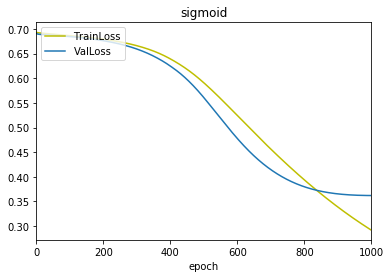

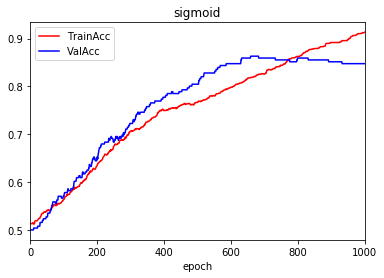

,loss,accuracy
training,0.292000,0.913000
validation,0.362000,0.848000
best validation,0.361907,0.863281


<Figure size 432x288 with 0 Axes>

In [12]:
listOfTrainLoss = np.asarray(Train_Loss)
listOfTrainAcc = np.asarray(Train_Acc)
listOfTestLoss = np.asarray(Val_Loss)
listOfTestAcc = np.asarray(Val_Acc)
plt.title(ActivationFuncion)
plt.xlabel('epoch')
plt.xlim(0,epoches)
plt.plot(listOfTrainLoss[:,0],listOfTrainLoss[:,1],c="y",label='TrainLoss')
plt.plot(listOfTestLoss[:,0],listOfTestLoss[:,1],label='ValLoss')
plt.legend(loc="upper left")
plt.show()
plt.title(ActivationFuncion)
plt.xlabel('epoch')
plt.xlim(0,epoches)
plt.plot(listOfTrainAcc[:,0],listOfTrainAcc[:,1],c="r",label='TrainAcc')
plt.plot(listOfTestAcc[:,0],listOfTestAcc[:,1],c="b",label='ValAcc')
plt.legend(loc="upper left")
plt.show()

fig = plt.figure()

data = {'loss':[np.round(result[0][0],3),np.round(result[2][0],3),np.round(bestLoss[0],10)],'accuracy':[np.round(result[1],3),np.round(result[3],3),np.round(bestAcc,10)]}
frame = DataFrame(data,index=["training","validation","best validation"])
frame